# Minimal DDP Example with MNIST Dataset
Just a quick example to make sure I get the basics of multi-GPU training with PyTorch's Distributed Data Parallel (DDP).

Meet `mini-mnist_ddp.py`:

In [ ]:
# Based on multiprocessing example from
# https://yangkky.github.io/2019/07/08/distributed-pytorch-tutorial.html

import time
import torch
import torch.nn as nn
import torch.distributed as dist
import torchvision.transforms as transforms
import wandb
from torchvision.datasets import MNIST
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel
from torch.utils.data import DataLoader
from statistics import mean

class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

# Gather any object from the other GPUs and return a list
def ddp_gather(o):
    o_all = [None for _ in range(dist.get_world_size())]
    dist.all_gather_object(o_all, o)
    return o_all

def train():
    dist.init_process_group(backend='nccl')

    seed = 42
    torch.manual_seed(seed)

    is_master = dist.get_rank() == 0  
    world_size = dist.get_world_size()
    local_rank = dist.get_rank()
    torch.cuda.set_device(local_rank)
    num_epochs = 10
    batch_size = 200
    batch_size_per_device = batch_size // world_size
    lr = 1e-4
    log_steps = 50

    if is_master: wandb.init(project="MiNiST-DDP", name=f"{world_size}-GPUs")

    model = ConvNet().cuda()
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    # Wrap model AFTER optimizer setup
    model = DistributedDataParallel(model, device_ids=[local_rank])

    train_dataset = MNIST(
        root = './data', 
        train = True,
        transform = transforms.ToTensor(), 
        download = True
    )
    train_sampler = DistributedSampler(
        train_dataset, 
        shuffle = True,
        seed = seed
    )
    train_loader = DataLoader(
        dataset = train_dataset, 
        batch_size = batch_size_per_device,
        sampler = train_sampler,
        shuffle = False,
        num_workers = 0, 
        pin_memory = True,
    )

    losses = [] 
    step = 0
    sample_count = 0
    last_step_time = time.time()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images = images.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            step += 1
            sample_count += len(images)
            losses.append(loss.item()) # losses = local (per GPU) losses 

            if step % log_steps == 0:
                loss_world = ddp_gather(losses) # all losses = list of lists = [[GPU1], [GPU2], ..]
                if is_master:
                    loss_world = [l for loss_gpu in loss_world for l in loss_gpu]  # flatten the list
                    # sample throughput (per sec)
                    sample_tp = (batch_size_per_device * world_size * log_steps) / (time.time() - last_step_time)
                    metrics = dict(
                        step = step,
                        loss = mean(loss_world),
                        sample_count = sample_count * world_size, # sample count is the same on every process
                        sample_tp = sample_tp,
                    )
                    wandb.log(metrics)
                    print(", ".join([f"{k}: {round(metrics[k],2) if isinstance(metrics[k], float) else metrics[k]}" for k in metrics]))
                # reset losses on every log step
                losses = []
                last_step_time = time.time()

    if is_master: wandb.finish()
    dist.destroy_process_group()

if __name__ == '__main__':
    train()


Take two 3090s and run
```
torchrun --nproc-per-node 1 mini-mnist_ddp.py
torchrun --nproc-per-node 2 mini-mnist_ddp.py
```

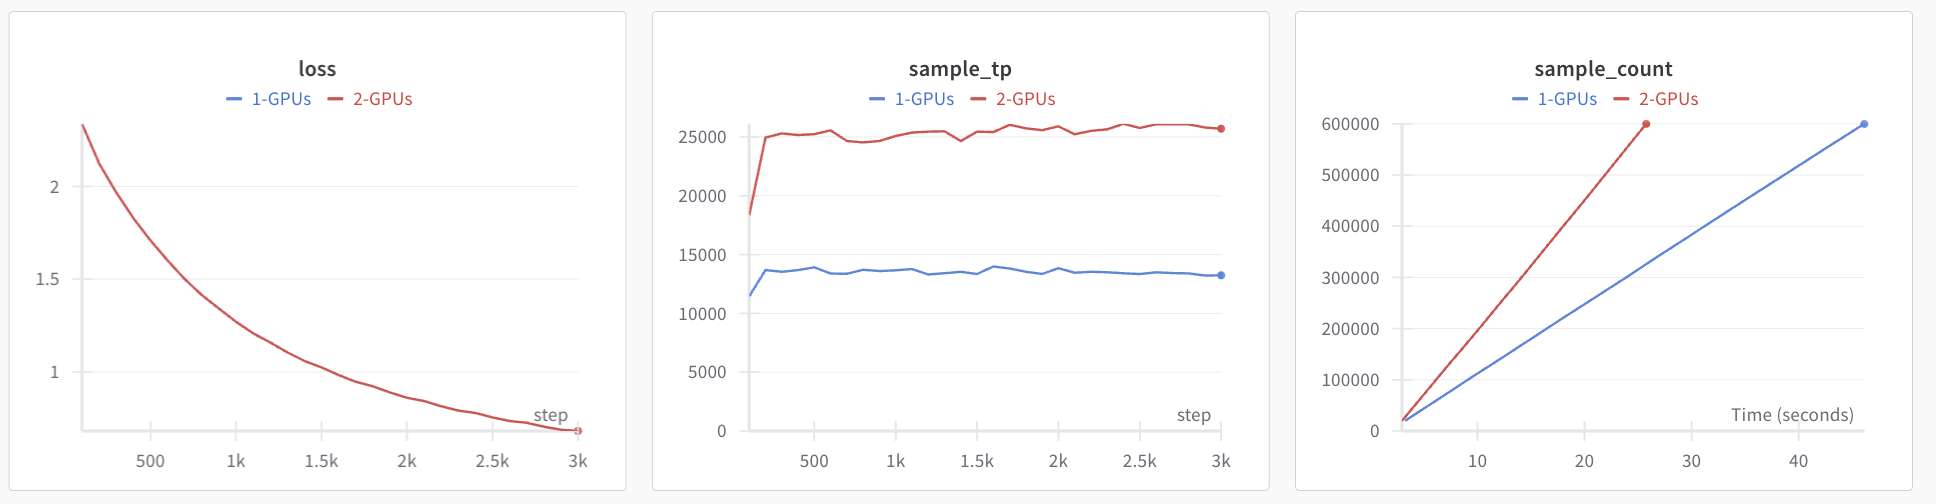